# 介绍
PGL 是一个用paddlepaddle实现的图神经网络(GNN)框架，它可以方便用户快速构建自己的图神经网络模型。

为了让用户快速上手，本教程的主要目的是：
* 理解PGL是如何在图网络上进行计算的。
* 使用PGL实现一个简单的图神经网络模型，用于对图网络中的节点进行二分类。

### 第一步：使用PGL创建一个图网络

In [1]:
import pgl
from pgl import graph  # 导入pgl的图模块
import numpy as np

def build_graph():
    # 定义节点的个数；每个节点用一个数字表示，即从0~9
    num_node = 10
    # 添加节点之间的边，每条边用一个tuple表示为: (src, dst)
    edge_list = [(2, 0), (2, 1), (3, 1),(4, 0), (5, 0), 
             (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
             (7, 2), (7, 3), (8, 0), (9, 7)]

    # 每个节点可以用一个d维的特征向量作为表示，这里随机产生节点的向量表示.
    # 在PGL中，我们可以使用numpy来添加节点的向量表示。
    d = 16
    feature = np.random.randn(num_node, d).astype("float32")
    #feature = np.array(feature,  dtype="float32")
    # 对于边，也同样可以用边的权重作为边特征
    edge_feature = np.random.randn(len(edge_list), 1).astype("float32")
 
    # 根据节点，边以及对应的特征向量，创建一个完整的图网络。
    # 在PGL中，节点特征和边特征都是存储在一个dict中。
    g = graph.Graph(num_nodes = num_node,
                    edges = edge_list, 
                    node_feat = {'feature':feature}, 
                    edge_feat ={'edge_feature': edge_feature})

    return g

In [2]:
# 创建一个图对象，用于保存图网络的各种数据。
g = build_graph()

In [3]:
# 打印图的节点的数量和边的数量
print('There are %d nodes in the graph.'%g.num_nodes)
print('There are %d edges in the graph.'%g.num_edges)

There are 10 nodes in the graph.
There are 14 edges in the graph.


除了打印节点，我们也可以可视化整个图网络，下面演示如何绘图显示整个图网络。

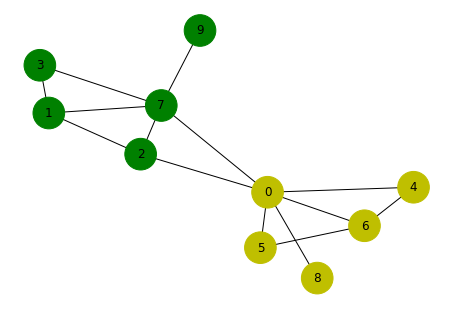

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx # networkx是一个常用的绘制复杂图形的Python包。

def display_graph(g):
    nx_G = nx.Graph()
    nx_G.add_nodes_from(range(g.num_nodes))
    for line in g.edges:
        nx_G.add_edge(*line)
    nx.draw(nx_G, with_labels=True,
            node_color=['y','g','g','g','y','y','y','g','y','g'], node_size=1000)
    foo_fig = plt.gcf() # 'get current figure'
    foo_fig.savefig('gcn.png', format='png', dpi=1000)
    #foo_fig.savefig('./foo.pdf', format='pdf')  # 也可以保存成pdf

    plt.show()

display_graph(g)# 创建一个GraphWrapper作为图数据的容器，用于构建图神经网络。



在PGL中，图对象用于保存各种图数据。我们还需要用到GraphWrapper作为图数据的容器，用于构建图神经网络。

In [5]:
import paddle.fluid as fluid
use_cuda = False  
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

gw = pgl.graph_wrapper.GraphWrapper(name='graph',
                place = place,
                node_feat=g.node_feat_info(),
                edge_feat=g.edge_feat_info())

### 第二步：构建一个图卷积网络模型(GCN)

在本教程中，我们使用图卷积网络模型([Kipf和Welling](https://arxiv.org/abs/1609.02907))来实现节点分类器。为了方便，这里我们使用最简单的GCN结构。如果读者想更加深入了解GCN，可以参考原始论文。

* 在第$l$层中，每个节点$u_i^l$都有一个特征向量$h_i^l$;
* 在每一层中，GCN的想法是下一层的每个节点$u_i^{l+1}$的特征向量$h_i^{l+1}$是由该节点的所有邻居节点的特征向量加权后经过一个非线性变换后得到的。

GCN模型符合消息传递模式(message-passing paradigm)，当一个节点的所有邻居节点把消息发送出来后，这个节点就可以根据上面的定义更新自己的特征向量了。

在PGL中，我们可以很容易实现一个GCN层。如下所示：

In [6]:
# 自定义GCN层函数
def gcn_layer(gw, nfeat, efeat, hidden_size, name, activation):
    # gw是一个GraphWrapper；feature是节点的特征向量。
    
    # 定义message函数，
    def send_func(src_feat, dst_feat, edge_feat): 
        # 注意： 这里三个参数是固定的，虽然我们只用到了第一个参数。
        # 在本教程中，我们直接返回源节点的特征向量作为message。用户也可以自定义message函数的内容。
        return src_feat['h'] * edge_feat['e']

    # 定义reduce函数，参数feat其实是从message函数那里获得的。
    def recv_func(feat):
        # 这里通过将源节点的特征向量进行加和。
        # feat为LodTensor，关于LodTensor的介绍参照Paddle官网。
        return fluid.layers.sequence_pool(feat, pool_type='sum')

    # send函数触发message函数，发送消息，并将返回消息。
    msg = gw.send(send_func, nfeat_list=[('h', nfeat)], efeat_list=[('e', efeat)])
    # recv函数接收消息，并触发reduce函数，对消息进行处理。
    output = gw.recv(msg, recv_func) 
    # 以activation为激活函数的全连接输出层。
    output = fluid.layers.fc(output, size=hidden_size, bias_attr=False, act=activation, name=name)
    return output

在定义好GCN层之后，我们可以构建一个更深的GCN模型，如下我们定一个两层GCN。

In [7]:
# 第一层GCN将特征向量从16维映射到8维，激活函数使用relu。
output = gcn_layer(gw, gw.node_feat['feature'], gw.edge_feat['edge_feature'], 
                   hidden_size=8, name='gcn_layer_1', activation='relu')
# 第二层GCN将特征向量从8维映射导2维，对应我们的二分类。不使用激活函数。
output = gcn_layer(gw, output, gw.edge_feat['edge_feature'], 
                   hidden_size=1, name='gcn_layer_2', activation=None)

### 第三步：数据预处理

由于我们实现一个节点二分类器，所以我们可以使用0，1分别表示两个类。

In [8]:
y = [0,1,1,1,0,0,0,1,0,1]
label = np.array(y, dtype="float32")
label = np.expand_dims(label, -1)

### 第四步：设置训练程序
GCN的训练过程跟训练其它基于paddlepaddle的模型是一样的。
* 首先我们构建损失函数；
* 接着创建一个优化器；
* 最后创建执行器并执行训练过程。

In [9]:
# 创建一个标签层作为节点类别标签的容器。
node_label = fluid.layers.data("node_label", shape=[None, 1], dtype="float32", append_batch_size=False)
# 使用带sigmoid的交叉熵函数作为损失函数
loss = fluid.layers.sigmoid_cross_entropy_with_logits(x=output, label=node_label)
# 计算平均损失
loss = fluid.layers.mean(loss)

# 选择Adam优化器，学习率设置为0.01
adam = fluid.optimizer.Adam(learning_rate=0.01)
adam.minimize(loss)

# 创建执行器
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())
feed_dict = gw.to_feed(g) # 获取图数据

for epoch in range(30):
    feed_dict['node_label'] = label
    
    train_loss = exe.run(fluid.default_main_program(), feed=feed_dict, fetch_list=[loss], return_numpy=True)
    print('Epoch %d | Loss: %f'%(epoch, train_loss[0]))

Epoch 0 | Loss: 0.629119
Epoch 1 | Loss: 0.614591
Epoch 2 | Loss: 0.602767
Epoch 3 | Loss: 0.593824
Epoch 4 | Loss: 0.587454
Epoch 5 | Loss: 0.581866
Epoch 6 | Loss: 0.576963
Epoch 7 | Loss: 0.572337
Epoch 8 | Loss: 0.567905
Epoch 9 | Loss: 0.563806
Epoch 10 | Loss: 0.559831
Epoch 11 | Loss: 0.555969
Epoch 12 | Loss: 0.552211
Epoch 13 | Loss: 0.548553
Epoch 14 | Loss: 0.544992
Epoch 15 | Loss: 0.541524
Epoch 16 | Loss: 0.538145
Epoch 17 | Loss: 0.534852
Epoch 18 | Loss: 0.531641
Epoch 19 | Loss: 0.528505
Epoch 20 | Loss: 0.525442
Epoch 21 | Loss: 0.522446
Epoch 22 | Loss: 0.519513
Epoch 23 | Loss: 0.516638
Epoch 24 | Loss: 0.513819
Epoch 25 | Loss: 0.511053
Epoch 26 | Loss: 0.508336
Epoch 27 | Loss: 0.505668
Epoch 28 | Loss: 0.503046
Epoch 29 | Loss: 0.500472
